In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
import pickle
from scipy.interpolate import splev, splrep, UnivariateSpline, InterpolatedUnivariateSpline
from settings import *
from matplotlib.lines import Line2D
from tools import *

In [11]:
import seaborn as sns
matplotlib = sns.mpl
plt = matplotlib.pyplot
plt.style.use("../style.mplstyle")
colorlist = plt.rcParams["axes.prop_cycle"].by_key()["color"]
warnings.filterwarnings("ignore")

In [ ]:
fontsize = "x-large"


### First, get all effective areas (calculated in alternative_plenum_aeff.ipynb)

In [6]:
with open("../resources/tabulated_logE_sindec_aeff_full.pckl", "rb") as f:
    log_ebins, sindec_bins, aeff_2d = pickle.load(f)

log_emids = get_mids(log_ebins)
ebins = np.power(10, log_ebins)
emids = get_mids(ebins)
ewidth = np.diff(ebins)

sindec_mids = get_mids(sindec_bins)
sindec_width = np.diff(sindec_bins)

ra_bins = np.linspace(0, np.pi*2, num=101)
ra_mids = (ra_bins[1:] + ra_bins[:-1]) * 0.5
ra_width = ra_bins[1:] - ra_bins[:-1]

# with two dimensions: sindec, energy
aeff_eval_e_sd = lambda aeff: (aeff * sindec_width).T * ewidth * np.sum(ra_width) # = 2pi

print(len(emids), "log_10(energy) bins")
print(len(sindec_mids), "declination bins")
print(len(ra_mids), "RA bins")

40 log_10(energy) bins
50 declination bins
100 RA bins


In [16]:
cz, ratio = np.loadtxt("../resources/ratio_IC_IC2.txt")
spl_a_ratio = UnivariateSpline(cz[::-1], ratio[::-1], k=1, s=0)

## Get the detection efficiencies as a function of sin(dec) based on the calculation in plenum_skymap_illustrations.ipynb

In [7]:
with open("../resources/detection_efficiencies.pckl", "rb") as f:
    det_eff, padded_sd = pickle.load(f)

In [7]:
## IC2
det = "IceCube-2"
### calculate raw neutrino rate ~ detection efficiency
# Res = integral dE ( A_eff * (E/GeV)**(-gamma) ) / delta sindec
for ii, gamma in enumerate(np.round(np.arange(1.4, 3.6, step=0.1), decimals=1)):
    Res = np.sum(
        aeff_eval_e_sd(
            aeff_2d["IceCube"] * spl_a_ratio(sindec_mids)) * (emids/E_NORM)**(-gamma), 
        axis=-1)
    # pad with boundary values such that the detection efficiency 
    # is defined up to sindec of -1 and 1
    padded_sd = np.concatenate([[-1], sindec_mids, [1]])
    padded_res = np.concatenate([[Res[0]], Res, [Res[-1]]])
    det_eff[gamma][det] = InterpolatedUnivariateSpline(padded_sd, np.log(padded_res))

### get the current discovery potential

In [8]:
ps_disc = dict()
ind_disc = dict()
xsd = dict()
ic_10yr = dict()
spl_10yr = dict()


gamma = 2.0
ps_disc[gamma] = np.genfromtxt('../resources/tcarver_10y_disc.csv', delimiter=',')
gamma = 2.5
ps_disc[gamma] = np.genfromtxt('../resources/10yr_ps_dicPot_g25_tessaThesis.csv', delimiter=',')
gamma = 3.0
ps_disc[gamma] = np.genfromtxt('../resources/10yr_ps_dicPot_g3_tessaThesis.csv', delimiter=',')
### result from 7yr analysis, if wanted
disc_7yr = np.genfromtxt('../resources/PSdiscPot7years.csv', delimiter=',')
sdec_7yr = disc_7yr[:,0]
disc_7yr = disc_7yr[:,1]

for gamma in ps_disc:
    ind_disc[gamma] = np.argsort(ps_disc[gamma][:,0])
    xsd[gamma] = ps_disc[gamma][:,0][ind_disc[gamma] ]
    ic_10yr[gamma] = ps_disc[gamma][:,1][ind_disc[gamma] ]
    spl_10yr[gamma] = splrep(xsd[gamma], ic_10yr[gamma])

In [9]:
reference_ddecs = np.array([sgr_a.icrs.dec.deg, ngc1068.dec.deg, 30])
reference_sdecs = np.sin(np.deg2rad(reference_ddecs))

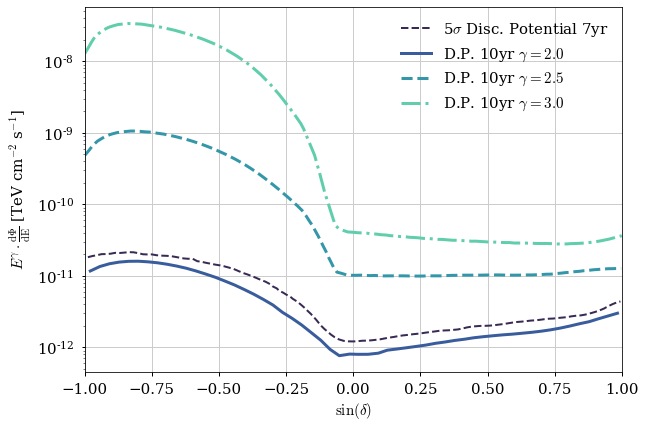

In [12]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(sdec_7yr, disc_7yr, ls='--', label="5$\sigma$ Disc. Potential 7yr")
gamma = 2.0 
ax.plot(xsd[gamma], ic_10yr[gamma], ls='-', lw=3, label=fr'D.P. 10yr $\gamma={gamma}$')
gamma = 2.5
ax.plot(xsd[gamma], ic_10yr[gamma], ls='--', lw=3, label=fr'D.P. 10yr $\gamma={gamma}$')
gamma = 3.0
ax.plot(xsd[gamma], ic_10yr[gamma], ls='-.', lw=3, label=fr'D.P. 10yr $\gamma={gamma}$')

ax.legend(loc='upper right', ncol=1, frameon=False)
ax.set_xlabel(r'$\sin(\delta)$')
ax.set_ylabel(r'$E^{\gamma} \cdot \frac{\rm d\Phi}{\rm dE}$ [TeV cm$^{-2}$ s$^{-1}$]')
ax.set_yscale('log')
ax.set_xlim(-1, 1)
fig.tight_layout()


### Idea:
* Discovery potential improvement for same time -> translated from scaling in effective area

$R = \frac{\Phi_0}{\Phi_{\rm new}} = \left( \frac{t_0}{t_{\rm new}} \right)^{-0.8} = \left( \frac{t_{\rm new}}{t_0} \right)^{0.8} = \left( \frac{\int dE \cdot A_{\rm eff, new} \cdot d\Phi/dE}{\int dE A_{\rm eff, 0} \cdot d\Phi/dE} \right)^{0.8} \equiv \left( \frac{\epsilon_{\rm new}}{\epsilon_{\rm IC}} \right)^{0.8}$

$\Rightarrow \Phi_{\rm new} = \frac{\Phi_{IC}}{R} = \Phi_{IC} \cdot \left( \frac{\epsilon_{\rm IC}}{\epsilon_{\rm new}} \right)^{0.8}$ (with detection efficiency = $\epsilon$)

* Alternative: adding known discovery potentials via
$ \Phi_{add} = \Phi_0 \oplus \Phi_1  := \left( \Phi_0^{-1/0.8} + \Phi_1^{-1/0.8} \right)^{-0.8} $

In [13]:
from matplotlib.legend_handler import HandlerBase

class AnyObjectHandler(HandlerBase):
    def create_artists(self, legend, orig_handle,
                       x0, y0, width, height, fontsize, trans):
        l1 = plt.Line2D(
            [x0,y0+width], [0.7*height,0.7*height], color='tab:blue', lw=3)
        l2 = plt.Line2D(
            [x0,y0+width], [0.3*height,0.3*height], color='tab:orange', lw=3)
        return [l1, l2]

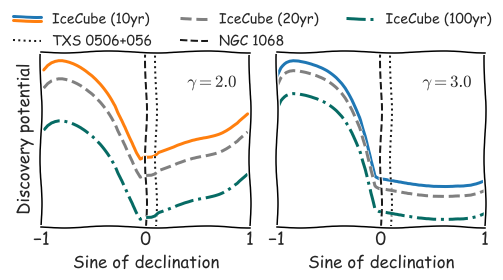

In [12]:
### simple sketchy plot as teaser
with plt.xkcd():
    f, axes = plt.subplots(ncols=2, figsize=(7, 4))
    gamma= 2.0
    ax = axes[0]

    ic_20yr = ps_disc[gamma][:,1][ind_disc[gamma] ] * (0.5 ** 0.8) # double time from 10yr baseline to 20yr
    ic_50yr = ps_disc[gamma][:,1][ind_disc[gamma] ] * (0.2 ** 0.8) # double time from 10yr baseline to 50yr
    ic_100yr = ps_disc[gamma][:,1][ind_disc[gamma] ] * (0.1 ** 0.8) # double time from 10yr baseline to 100yr
    
    ax.plot(xsd[gamma], ic_10yr[gamma], color="tab:orange", ls="-", lw=3)
    ax.axvline(np.sin(txs0506.icrs.dec), ls=":", color="k", label="TXS 0506+056")
    ax.plot(xsd[gamma], ic_20yr, color="gray", ls="--", lw=3, label=r'IceCube (20yr)')
    ax.axvline(np.sin(ngc1068.icrs.dec), ls="--", color="k", label="NGC 1068")
    ax.plot(xsd[gamma], ic_100yr, color=colors[2], ls="-.", lw=3, label=r'IceCube (100yr)')

    ax.set_xlabel("Sine of declination", fontsize="large")
    ax.set_yscale('log')
    ax.set_yticks([])
    ax.set_xlim(-1, 1)
    ax.text(0.7, 0.8, r'$\gamma={0:.1f}$'.format(gamma), fontsize=fontsize, transform = ax.transAxes)
    ax.set_ylabel(r"Discovery potential", fontsize="large")
    ax.tick_params(axis='both', which='both', length=0)
    
    handles, labels = ax.get_legend_handles_labels()
    handles.insert(0, object)
    labels.insert(0, r'IceCube (10yr)')
    f.legend(
        handles, labels, handler_map={object: AnyObjectHandler()},
        loc='upper center', ncol=3, frameon=False, fontsize="medium"
    )

    gamma = 3.0
    ax = axes[1]
    ic_20yr = ps_disc[gamma][:,1][ind_disc[gamma] ] * (0.5 ** 0.8) # double time from 10yr baseline to 20yr
    ic_50yr = ps_disc[gamma][:,1][ind_disc[gamma] ] * (0.2 ** 0.8) # double time from 10yr baseline to 50yr
    ic_100yr = ps_disc[gamma][:,1][ind_disc[gamma] ] * (0.1 ** 0.8) # double time from 10yr baseline to 100yr
    
    ax.plot(xsd[gamma], ic_10yr[gamma], color="tab:blue", ls="-", lw=3)
    ax.axvline(np.sin(txs0506.icrs.dec), ls=":", color="k", label="TXS 0506+056")
    ax.plot(xsd[gamma], ic_20yr, color="gray", ls="--", lw=3, label=r'IceCube (20yr)')
    ax.axvline(np.sin(ngc1068.icrs.dec), ls="--", color="k", label="NGC 1068")
    ax.plot(xsd[gamma], ic_100yr, color=colors[2], ls="-.", lw=3, label=r'IceCube (100yr)')

    ax.set_xlabel("Sine of declination", fontsize=fontsize)
    ax.set_yscale('log')
    ax.set_yticks([])
    ax.set_xlim(-1, 1)
    ax.text(0.7, 0.8, r'$\gamma={0:.1f}$'.format(gamma), fontsize="large", transform = ax.transAxes)
    ax.tick_params(axis='both', which='both', length=0)
    f.tight_layout()
    plt.subplots_adjust(top = 0.82)
    f.savefig(f'../plots/PLENUM_ps_disc_pot_comparison_sketch.pdf', bbox_inches="tight")

# PS scaling

In [17]:
gen2 = dict()
ic_20yr = dict()
ic_ntn = dict()
pone = dict()
ic_2 = dict()
ic_ic_2 = dict()
plenum1 = dict()
plenum2 = dict()
ic_plenum1 = dict()
ic_plenum2 = dict()

In [20]:
for gamma in [2.0, 2.5, 3.0]:
    ic_20yr[gamma] = ps_disc[gamma][:,1][ind_disc[gamma] ] * (0.5 ** 0.8) # double time from 10yr baseline to 20yr
    # plenum-1 10yr
    ic_ntn[gamma] = ps_disc[gamma][:,1][ind_disc[gamma] ] \
        * (np.exp(det_eff[gamma]["IceCube"](xsd[gamma])) / (np.exp(det_eff[gamma]["IceCube"](xsd[gamma])) + np.exp(det_eff[gamma]["P-ONE"](xsd[gamma])))) ** 0.8
    # pone 10yr
    pone[gamma] = ps_disc[gamma][:,1][ind_disc[gamma] ] \
        * np.exp((det_eff[gamma]["IceCube"](xsd[gamma]) - det_eff[gamma]["P-ONE"](xsd[gamma]))* 0.8)
    # # ic_2 10yr
    # ic_2[gamma] = ps_disc[gamma][:,1][ind_disc[gamma] ] \
    #     * np.exp((det_eff[gamma]["IceCube"](xsd[gamma]) - det_eff[gamma]["IceCube-2"](xsd[gamma]))* 0.8)
    # gen2 10yr
    gen2[gamma] = ps_disc[gamma][:,1][ind_disc[gamma] ] \
        * np.exp((det_eff[gamma]["IceCube"](xsd[gamma]) - det_eff[gamma]["Gen-2"](xsd[gamma]))* 0.8)
    # plenum-1 10yr
    plenum1[gamma] = ps_disc[gamma][:,1][ind_disc[gamma] ] \
        * np.exp((det_eff[gamma]["IceCube"](xsd[gamma]) - det_eff[gamma]["Plenum-1"](xsd[gamma]))* 0.8)
    # plenum-2 10yr
    plenum2[gamma] = ps_disc[gamma][:,1][ind_disc[gamma] ] \
        * np.exp((det_eff[gamma]["IceCube"](xsd[gamma]) - det_eff[gamma]["Plenum-2"](xsd[gamma]))* 0.8)
    # 10 yr icecube, then 10yr plenum-1 (with icecube)
    ic_plenum1[gamma] = (ic_10yr[gamma] ** (-1/0.8) + plenum1[gamma] ** (-1/0.8)) ** -0.8
    # # 10 yr icecube, then 10yr icecube-2
    # ic_ic_2[gamma] = (ic_10yr[gamma] ** (-1/0.8) + ic_2[gamma] ** (-1/0.8)) ** -0.8
    # 10 yr icecube, then 10yr plenum-2 (with gen2)
    ic_plenum2[gamma] = (ic_10yr[gamma] ** (-1/0.8) + plenum2[gamma] ** (-1/0.8)) ** -0.8

#### IceCube Evolution

plot saved to ../plots/IC_ps_disc_pot_comparison_gamma2.pdf
plot saved to ../plots/IC_ps_disc_pot_comparison_gamma3.pdf


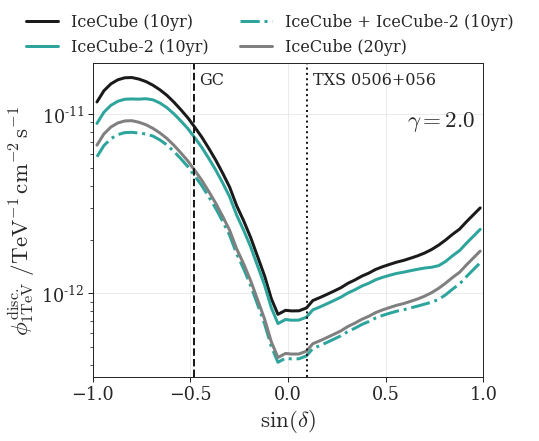

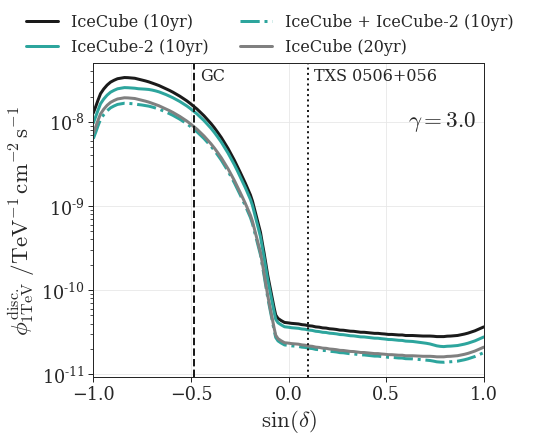

In [15]:
for gamma in [2.0, 3.0]:
    f, ax = plt.subplots(figsize=(7, 6))
    # conversion to flux normalisation at 100TeV in 1/GeV /cm2/s
    const = 1 #  10**(-2*gamma) / 1.e3
    ax.plot(
        xsd[gamma], ic_10yr[gamma] * const, color="k", ls="-", lw=3, label=r'IceCube (10yr)')
    ax.plot(
        xsd[gamma], ic_2[gamma] * const, color=colors[1], ls="-", lw=3, label=r'IceCube-2 (10yr)')
    ax.plot(
        xsd[gamma], ic_ic_2[gamma] * const, color=colors[1], ls="-.", lw=3, label=r'IceCube + IceCube-2 (10yr)')
    ax.plot(
        xsd[gamma], ic_20yr[gamma] * const, color="gray", ls="-", lw=3, label=r'IceCube (20yr)')
    
    ax.axvline(np.sin(txs0506.icrs.dec), ls=":", color="k")
    ax.axvline(np.sin(sgr_a.icrs.dec), ls="--", color="k")
    
    ax.set_xlabel(r'$\sin(\delta)$', fontsize="large")
    ax.set_yscale('log')
    ax.set_xlim(-1, 1)
    ax.text(0.98, 0.8, r'$\gamma={0:.1f}$'.format(gamma), fontsize="large", transform=ax.transAxes, ha="right")
    ax.set_ylabel(r"$\phi^{\mathrm{disc.}}_{1\rm TeV} ~ / \rm TeV^{-1} \, cm^{-2} \, s^{-1}$", fontsize="large")
    ax.tick_params(axis='both', which='major')
    f.legend(loc='upper center', ncol=2, frameon=False, fontsize="small")
    plt.subplots_adjust(top = 0.85)
    
    ylim = ax.get_ylim()
    ax.text(np.sin(sgr_a.icrs.dec)+0.03, ylim[1]*0.9, "GC", fontsize="small", va="top")
    ax.text(np.sin(txs0506.icrs.dec)+0.03, ylim[1]*0.9, "TXS 0506+056", fontsize="small", va="top")
    f.savefig(f'../plots/IC+P-ONE_ps_disc_pot_comparison_gamma{int(gamma)}.pdf', bbox_inches="tight")
    print("plot saved to", f'../plots/IC_ps_disc_pot_comparison_gamma{int(gamma)}.pdf')
    

(1.0, 1.34716945968785)

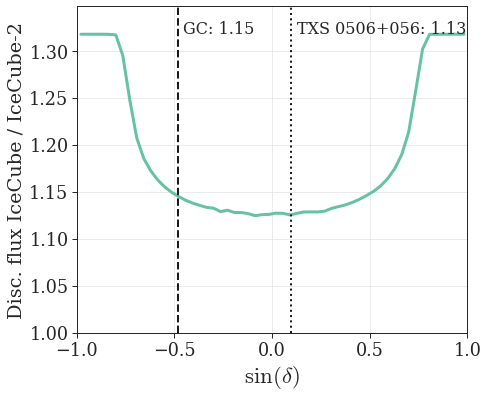

In [16]:
f, ax = plt.subplots(figsize=(7, 6))
ax.plot(xsd[2.0], ic_10yr[2.0] / ic_2[2.0], ls="-", lw=3, label=fr"$\gamma={gamma}$")
ax.set_ylabel(r'Disc. flux IceCube / IceCube-2')
ax.axvline(np.sin(txs0506.icrs.dec), ls=":", color="k")
ax.axvline(np.sin(sgr_a.icrs.dec), ls="--", color="k")
ax.set_xlabel(r'$\sin(\delta)$', fontsize="large")
ax.set_xlim(-1, 1)
ax.tick_params(axis='both', which='major')
ylim = ax.get_ylim()
ax.text(np.sin(sgr_a.icrs.dec)+0.03, ylim[1]+0.005, f"GC: {spl_a_ratio(np.sin(sgr_a.icrs.dec))**0.8:1.2f}", fontsize="small", va="top")
ax.text(np.sin(txs0506.icrs.dec)+0.03, ylim[1]+0.005, f"TXS 0506+056: {spl_a_ratio(np.sin(txs0506.icrs.dec))**0.8:1.2f}", fontsize="small", va="top")
ax.set_ylim(1, ylim[1]+0.02)

In [44]:
fontsize = 15

plot saved to ../plots/IC+P-ONE_ps_disc_pot_comparison_gamma2.pdf
plot saved to ../plots/IC+P-ONE_ps_disc_pot_comparison_gamma3.pdf


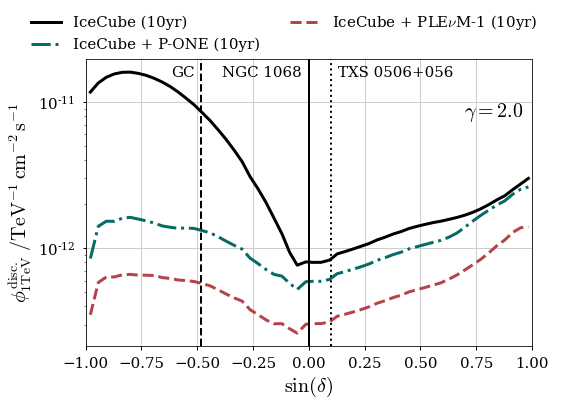

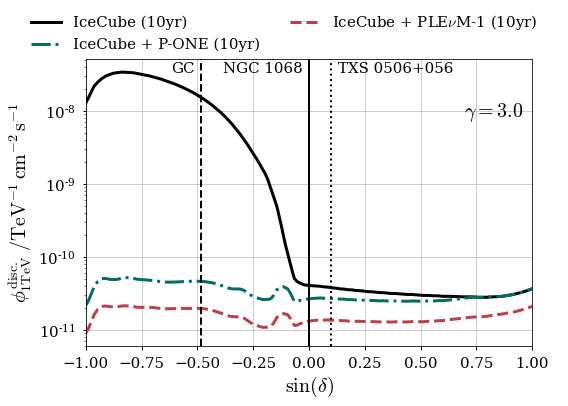

In [48]:
for gamma in [2.0, 3.0]:
    f, ax = plt.subplots()#figsize=(7, 6))
    # conversion to flux normalisation at 100TeV in 1/GeV /cm2/s
    const = 1 #  10**(-2*gamma) / 1.e3
    ax.plot(
        xsd[gamma], ic_10yr[gamma] * const, color="k", ls="-", lw=3, label=r'IceCube (10yr)')
    ax.plot(
        xsd[gamma], ic_ntn[gamma] * const, color=colors[2], ls="-.", lw=3, label=r'IceCube + P-ONE (10yr)')
    #ax.plot(
    #    xsd[gamma], ic_20yr[gamma] * const, color="gray", ls="-", lw=3, label=r'IceCube (20yr)')
    ax.plot(
        xsd[gamma], ic_plenum1[gamma] * const, color=colors[3], ls="--", lw=3, label=r'IceCube + PLE$\nu$M-1 (10yr)')
    #ax.plot(
    #    xsd[gamma], ic_plenum2[gamma] * const, color=colors[3], lw=3, label=r'IceCube + PLE$\nu$M-2 (10yr)')
    
    ax.axvline(np.sin(txs0506.icrs.dec), ls=":", color="k")
    ax.axvline(np.sin(ngc1068.icrs.dec), ls="-", color="k")
    ax.axvline(np.sin(sgr_a.icrs.dec), ls="--", color="k")
    
    ax.set_yscale('log')
    ax.set_xlim(-1, 1)
    ax.tick_params(axis='both', which='major')
    f.legend(loc='upper center', ncol=2, frameon=False, fontsize=fontsize)
    plt.subplots_adjust(top = 0.85)
    
    ylim = ax.get_ylim()
    ax.text(0.98, 0.8, r'$\gamma={0:.1f}$'.format(gamma), fontsize=fontsize + 5, transform=ax.transAxes, ha="right")
    ax.text(np.sin(sgr_a.icrs.dec)-0.03, ylim[1]*0.9, "GC", fontsize=fontsize, va="top", ha="right")
    ax.text(np.sin(txs0506.icrs.dec)+0.03, ylim[1]*0.9, "TXS 0506+056", fontsize=fontsize, va="top")
    ax.text(np.sin(ngc1068.icrs.dec)-0.03, ylim[1]*0.9, "NGC 1068", fontsize=fontsize, va="top", ha="right")
    ax.set_xlabel(r'$\sin(\delta)$', fontsize=fontsize + 5)
    ax.set_ylabel(r"$\phi^{\mathrm{disc.}}_{1\rm TeV} ~ / \rm TeV^{-1} \, cm^{-2} \, s^{-1}$", fontsize=fontsize + 5)

    f.savefig(f'../plots/IC+P-ONE_ps_disc_pot_comparison_gamma{int(gamma)}.pdf', bbox_inches="tight")
    print("plot saved to", f'../plots/IC+P-ONE_ps_disc_pot_comparison_gamma{int(gamma)}.pdf')

plot saved to ../plots/IC+P-ONE_ps_disc_pot_comparison_gamma2.pdf
plot saved to ../plots/IC+P-ONE_ps_disc_pot_comparison_gamma3.pdf


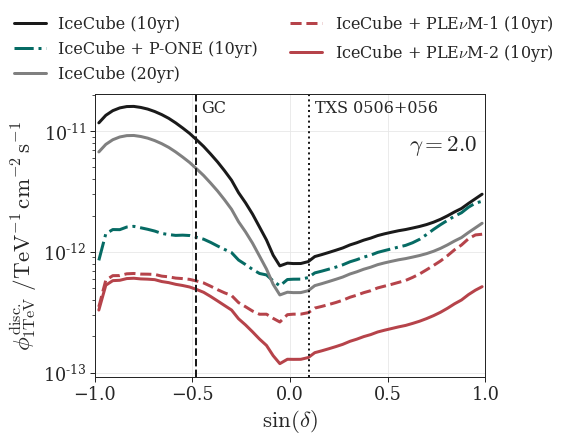

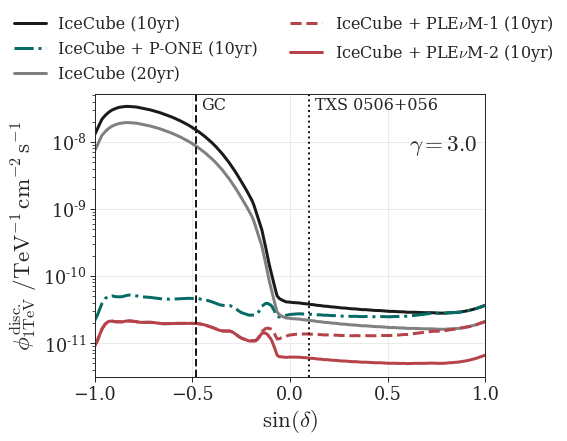

In [ ]:
for gamma in [2.0, 3.0]:
    f, ax = plt.subplots(figsize=(7, 6))
    # conversion to flux normalisation at 100TeV in 1/GeV /cm2/s
    const = 1 #  10**(-2*gamma) / 1.e3
    ax.plot(
        xsd[gamma], ic_10yr[gamma] * const, color="k", ls="-", lw=3, label=r'IceCube (10yr)')
    ax.plot(
        xsd[gamma], ic_ntn[gamma] * const, color=colors[2], ls="-.", lw=3, label=r'IceCube + P-ONE (10yr)')
    ax.plot(
        xsd[gamma], ic_20yr[gamma] * const, color="gray", ls="-", lw=3, label=r'IceCube (20yr)')
    ax.plot(
        xsd[gamma], ic_plenum1[gamma] * const, color=colors[3], ls="--", lw=3, label=r'IceCube + PLE$\nu$M-1 (10yr)')
    ax.plot(
        xsd[gamma], ic_plenum2[gamma] * const, color=colors[3], lw=3, label=r'IceCube + PLE$\nu$M-2 (10yr)')
    
    ax.axvline(np.sin(txs0506.icrs.dec), ls=":", color="k")
    ax.axvline(np.sin(sgr_a.icrs.dec), ls="--", color="k")
    
    ax.set_xlabel(r'$\sin(\delta)$', fontsize="large")
    ax.set_yscale('log')
    ax.set_xlim(-1, 1)
    ax.text(0.98, 0.8, r'$\gamma={0:.1f}$'.format(gamma), fontsize="large", transform=ax.transAxes, ha="right")
    ax.set_ylabel(r"$\phi^{\mathrm{disc.}}_{1\rm TeV} ~ / \rm TeV^{-1} \, cm^{-2} \, s^{-1}$", fontsize="large")
    ax.tick_params(axis='both', which='major')
    f.legend(loc='upper center', ncol=2, frameon=False, fontsize="small")
    plt.subplots_adjust(top = 0.78)
    
    ylim = ax.get_ylim()
    ax.text(np.sin(sgr_a.icrs.dec)+0.03, ylim[1]*0.9, "GC", fontsize="small", va="top")
    ax.text(np.sin(txs0506.icrs.dec)+0.03, ylim[1]*0.9, "TXS 0506+056", fontsize="small", va="top")
    f.savefig(f'../plots/IC+P-ONE_ps_disc_pot_comparison_gamma{int(gamma)}.pdf', bbox_inches="tight")
    print("plot saved to", f'../plots/IC+P-ONE_ps_disc_pot_comparison_gamma{int(gamma)}.pdf')

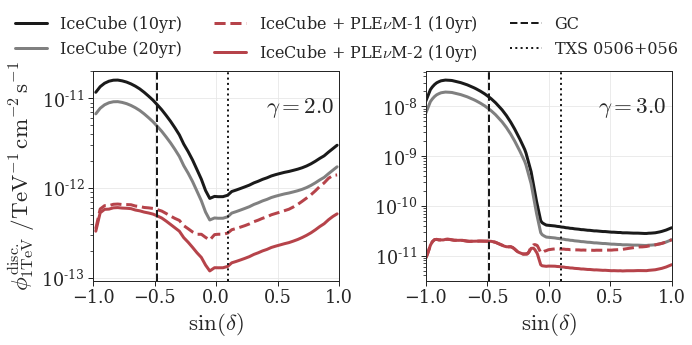

In [18]:
f, axes = plt.subplots(ncols=2, figsize=(10, 5))
gamma= 2.0
ax = axes[0]
# conversion to flux normalisation at 100TeV in 1/GeV /cm2/s
const = 1 #  10**(-2*gamma) / 1.e3
ax.plot(
    xsd[gamma], ic_10yr[gamma] * const, color="k", ls="-", lw=3, label=r'IceCube (10yr)')
ax.plot(
    xsd[gamma], ic_20yr[gamma] * const, color="gray", ls="-", lw=3, label=r'IceCube (20yr)')
ax.plot(
    xsd[gamma], ic_plenum1[gamma] * const, color=colors[3], ls="--", lw=3, label=r'IceCube + PLE$\nu$M-1 (10yr)')
ax.plot(
    xsd[gamma], ic_plenum2[gamma] * const, color=colors[3], lw=3, label=r'IceCube + PLE$\nu$M-2 (10yr)')

ax.set_xlabel(r'$\sin(\delta)$', fontsize="large")
ax.set_yscale('log')
ax.set_xlim(-1, 1)
ax.text(0.98, 0.8, r'$\gamma={0:.1f}$'.format(gamma), fontsize="large", transform=ax.transAxes, ha="right")
ax.set_ylabel(r"$\phi^{\mathrm{disc.}}_{1\rm TeV} ~ / \rm TeV^{-1} \, cm^{-2} \, s^{-1}$", fontsize="large")
ax.tick_params(axis='both', which='major')
# add the location of the galactic center and TXS
ax.axvline(np.sin(sgr_a.icrs.dec), ls="--", color="k", label="GC")
ax.axvline(np.sin(txs0506.icrs.dec), ls=":", color="k", label="TXS 0506+056")
#ax.text(0.25, 0.055, "GC", transform=ax.transAxes, fontsize="small")
#ax.text(0.5, 0.055, "TXS 0506+056", transform=ax.transAxes, fontsize="small")
f.legend(loc='upper center', ncol=3, frameon=False, fontsize="small")


gamma = 3.0
ax = axes[1]
# conversion to flux normalisation at 100TeV in 1/GeV /cm2/s
const = 1 #10**(-2*gamma) / 1.e3
ax.plot(
    xsd[gamma], ic_10yr[gamma] * const, color="k", ls="-", lw=3, label=r'IceCube (10yr)')
ax.plot(
    xsd[gamma], ic_20yr[gamma] * const, color="gray", ls="-", lw=3, label=r'IceCube (20yr)')
ax.plot(
    xsd[gamma], ic_plenum1[gamma] * const, color=colors[3], ls="--", lw=3, label=r'IceCube + PLE$\nu$M-1 (10yr)')
ax.plot(
    xsd[gamma], ic_plenum2[gamma] * const, color=colors[3], lw=3, label=r'IceCube + PLE$\nu$M-2 (10yr)')

ax.set_xlabel(r'$\sin(\delta)$', fontsize="large")
ax.set_yscale('log')
ax.set_xlim(-1, 1)
ax.text(0.98, 0.8, r'$\gamma={0:.1f}$'.format(gamma), fontsize="large", transform=ax.transAxes, ha="right")

ax.tick_params(axis='both', which='major')
# add the location of the galactic center and TXS
ax.axvline(np.sin(sgr_a.icrs.dec), ls="--", color="k", label="GC")
ax.axvline(np.sin(txs0506.icrs.dec), ls=":", color="k", label="TXS 0506+056")

f.tight_layout()
plt.subplots_adjust(top = 0.8)
f.savefig(f'../plots/PLENUM_ps_disc_pot_comparison_gamma20-30_woDots.pdf', bbox_inches="tight")

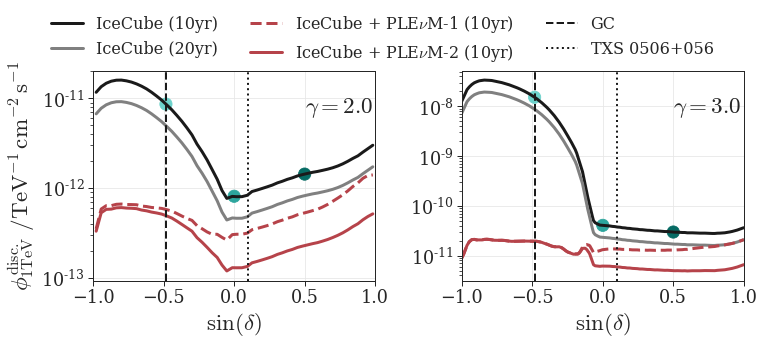

In [19]:
f, axes = plt.subplots(ncols=2, figsize=(11, 5))
gamma= 2.0
ax = axes[0]
# conversion to flux normalisation at 100TeV in 1/GeV /cm2/s
const = 1 #  10**(-2*gamma) / 1.e3
ax.plot(
    xsd[gamma], ic_10yr[gamma] * const, color="k", ls="-", lw=3, label=r'IceCube (10yr)')
ax.plot(
    xsd[gamma], ic_20yr[gamma] * const, color="gray", ls="-", lw=3, label=r'IceCube (20yr)')
ax.plot(
    xsd[gamma], ic_plenum1[gamma] * const, color=colors[3], ls="--", lw=3, label=r'IceCube + PLE$\nu$M-1 (10yr)')
ax.plot(
    xsd[gamma], ic_plenum2[gamma] * const, color=colors[3], lw=3, label=r'IceCube + PLE$\nu$M-2 (10yr)')
ax.scatter(
    reference_sdecs, 
    splev(reference_sdecs, spl_10yr[gamma]) * const,
    color=colors[:3],
    s=150,
    alpha=1
)
ax.set_xlabel(r'$\sin(\delta)$', fontsize="large")
ax.set_yscale('log')
ax.set_xlim(-1, 1)
ax.text(0.75, 0.8, r'$\gamma={0:.1f}$'.format(gamma), fontsize="large", transform = ax.transAxes)
ax.set_ylabel(r"$\phi^{\mathrm{disc.}}_{1\rm TeV} ~ / \rm TeV^{-1} \, cm^{-2} \, s^{-1}$", fontsize="large")
ax.tick_params(axis='both', which='major')
# add the location of the galactic center and TXS
ax.axvline(np.sin(sgr_a.icrs.dec), ls="--", color="k", label="GC")
ax.axvline(np.sin(txs0506.icrs.dec), ls=":", color="k", label="TXS 0506+056")
#ax.text(0.25, 0.055, "GC", transform=ax.transAxes, fontsize="small")
#ax.text(0.5, 0.055, "TXS 0506+056", transform=ax.transAxes, fontsize="small")
f.legend(loc='upper center', ncol=3, frameon=False, fontsize="small")


gamma = 3.0
ax = axes[1]
# conversion to flux normalisation at 100TeV in 1/GeV /cm2/s
const = 1 #10**(-2*gamma) / 1.e3
ax.plot(
    xsd[gamma], ic_10yr[gamma] * const, color="k", ls="-", lw=3, label=r'IceCube (10yr)')
ax.plot(
    xsd[gamma], ic_20yr[gamma] * const, color="gray", ls="-", lw=3, label=r'IceCube (20yr)')
ax.plot(
    xsd[gamma], ic_plenum1[gamma] * const, color=colors[3], ls="--", lw=3, label=r'IceCube + PLE$\nu$M-1 (10yr)')
ax.plot(
    xsd[gamma], ic_plenum2[gamma] * const, color=colors[3], lw=3, label=r'IceCube + PLE$\nu$M-2 (10yr)')
ax.scatter(
    reference_sdecs, 
    splev(reference_sdecs, spl_10yr[gamma]) * const,
    color=colors[:3],
    s=150,
    alpha=1
)
ax.set_xlabel(r'$\sin(\delta)$', fontsize="large")
ax.set_yscale('log')
ax.set_xlim(-1, 1)
ax.text(0.75, 0.8, r'$\gamma={0:.1f}$'.format(gamma), fontsize="large" ,
         transform = ax.transAxes)
ax.tick_params(axis='both', which='major')
# add the location of the galactic center and TXS
ax.axvline(np.sin(sgr_a.icrs.dec), ls="--", color="k", label="GC")
ax.axvline(np.sin(txs0506.icrs.dec), ls=":", color="k", label="TXS 0506+056")

f.tight_layout()
plt.subplots_adjust(top = 0.8)
f.savefig(f'../plots/PLENUM_ps_disc_pot_comparison_gamma20-30_Dots.pdf', bbox_inches="tight")

### Make a time evolution plot for the selected declinations

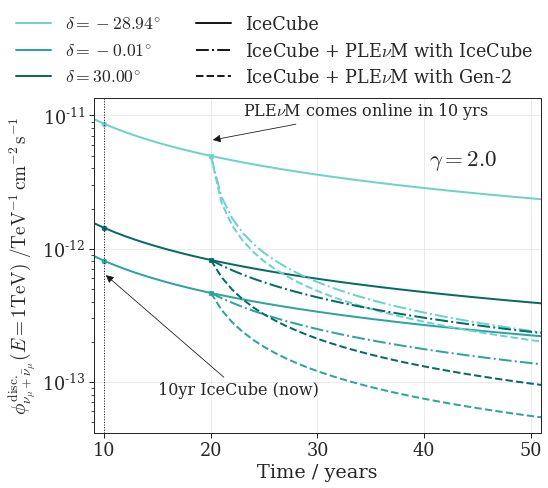

In [20]:
gamma = 2.0
# conversion to flux normalisation at 100TeV in 1/GeV /cm2/s
const = 1 #10**(-2*gamma) / 1.e3

t_0 = 10
t_new = np.arange(8, 52)
base_disc_10yr = splev(reference_sdecs, spl_10yr[gamma])

fig, ax = plt.subplots(figsize=(8, 7))
for i, dd in enumerate(reference_ddecs):
    time_evolution_base = base_disc_10yr[i] * (t_0 / t_new) ** 0.8
    p = ax.plot(t_new, time_evolution_base * const, label=fr"$\delta = {dd:1.2f}^{{\circ}}$", color=colors[i])
    ax.scatter(t_0, base_disc_10yr[i] * const, color=colors[i])
    
t_1 = 20
t_new = np.arange(20, 52) # start Plenum after 20yr IC data (10yrs after "now")
for i, dd in enumerate(reference_ddecs):
    # base values at t_1 = 20yr
    # IC with 20 years
    base_ic = base_disc_10yr[i] * (t_0 / t_1) ** 0.8
    # plenum reference for 10 yrs data taking
    base_plenum = base_disc_10yr[i] * np.exp((det_eff[gamma]["IceCube"](reference_sdecs[i]) - det_eff[gamma]["Plenum-1"](reference_sdecs[i]))* 0.8)
    
    # plenum with gen2 instead of icecube
    # first, subtract icecube eff from plenum eff
    pl_tmp = np.exp(det_eff[gamma]["Plenum-1"](reference_sdecs[i])) - np.exp(det_eff[gamma]["IceCube"](reference_sdecs[i]))
    # then, add gen2
    pl_tmp += np.exp(det_eff[gamma]["Gen-2"](reference_sdecs[i]))
    base_plenum_gen2 = base_disc_10yr[i] * np.exp((det_eff[gamma]["IceCube"](reference_sdecs[i]) - np.log(pl_tmp))* 0.8)
    # time evolution
    # plenum starts at t_1=20yrs
    base_plenum_evo = base_plenum * (t_0 / (t_new-t_1)) ** 0.8
    base_plenum_gen2_evo = base_plenum_gen2 * (t_0 / (t_new-t_1)) ** 0.8
    # combine both base vals
    # 20yr IceCube and from then on combined Plenum evolution
    time_evolution = (base_ic ** (-1/0.8) + base_plenum_evo ** (-1/0.8)) ** -0.8
    time_evolution_gen2 = (base_ic ** (-1/0.8) + base_plenum_gen2_evo ** (-1/0.8)) ** -0.8
    p = ax.plot(t_new, time_evolution * const, color=colors[i], ls="-.")
    p = ax.plot(t_new, time_evolution_gen2 * const, color=colors[i], ls="--")
    ax.scatter(t_new[0], time_evolution[0] * const, color=colors[i], marker="s")

ax.set_yscale('log')
ax.set_xlabel(r"Time / years")
ax.set_ylabel(r"$\phi^{\mathrm{disc.}}_{\nu_\mu + \bar{\nu}_\mu}(E=1\rm TeV) ~ / \rm TeV^{-1} \, cm^{-2} \, s^{-1}$")
ax.axvline(10, ls=":", lw=1, color="k")
ax.text(0.75, 0.8, r'$\gamma={0:.1f}$'.format(gamma), fontsize="large" ,
         transform = ax.transAxes)
ax.annotate(
    "10yr IceCube (now)",
    xy=(10, base_disc_10yr[1] * const * 0.8), xytext=(15, base_disc_10yr[1] * const * 0.1),
    arrowprops=dict(arrowstyle="-|>", color="k"),
    fontsize="small")
ax.annotate(
    r"PLE$\nu$M comes online in 10 yrs",
    xy=(20, 0.65e-11), xytext=(23, 1.e-11),
    arrowprops=dict(arrowstyle="-|>", color="k"),
    fontsize="small")
ax.set_xlim(9, 51)
handles, labels = ax.get_legend_handles_labels()
handles.append(Line2D(
    range(1), range(1), color="k", 
    ls="-", label="IceCube"
))
handles.append(Line2D(
    range(1), range(1), color="k", 
    ls="-.", label=r"IceCube + PLE$\nu$M with IceCube"
))
handles.append(Line2D(
    range(1), range(1), color="k", 
    ls="--", label=r"IceCube + PLE$\nu$M with Gen-2"
))
        
fig.legend(
    handles=handles,
    loc='upper center', #mode='expand',
    ncol=2, frameon=False
)
fig.tight_layout()
plt.subplots_adjust(top = 0.8)
fig.savefig(f'../plots/PLENUM_ps_disc_pot_timeevolution_gamma{gamma}.pdf', bbox_inches="tight")

## same plot, but gamma=2.5

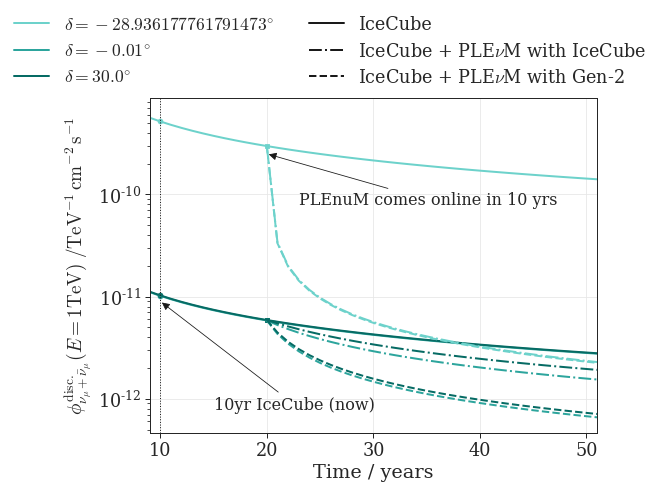

In [21]:
gamma = 2.5
# conversion to flux normalisation at 100TeV in 1/GeV /cm2/s
const = 1 #10**(-2*gamma) / 1.e3

t_0 = 10
t_new = np.arange(8, 52)
base_disc_10yr = splev(reference_sdecs, spl_10yr[gamma])

fig, ax = plt.subplots(figsize=(8, 7))
for i, dd in enumerate(reference_ddecs):
    time_evolution_base = base_disc_10yr[i] * (t_0 / t_new) ** 0.8
    p = ax.plot(t_new, time_evolution_base * const, label=fr"$\delta = {dd}^{{\circ}}$", color=colors[i])
    ax.scatter(t_0, base_disc_10yr[i] * const, color=colors[i])
    
t_1 = 20
t_new = np.arange(20, 52) # start Plenum after 20yr IC data (10yrs after "now")
for i, dd in enumerate(reference_ddecs):
    # base values at t_1 = 20yr
    # IC with 20 years
    base_ic = base_disc_10yr[i] * (t_0 / t_1) ** 0.8
    # plenum reference for 10 yrs data taking
    base_plenum = base_disc_10yr[i] * np.exp((det_eff[gamma]["IceCube"](reference_sdecs[i]) - det_eff[gamma]["Plenum-1"](reference_sdecs[i]))* 0.8)
    
    # plenum with gen2 instead of icecube
    # first, subtract icecube eff from plenum eff
    pl_tmp = np.exp(det_eff[gamma]["Plenum-1"](reference_sdecs[i])) - np.exp(det_eff[gamma]["IceCube"](reference_sdecs[i]))
    # then, add gen2
    pl_tmp += np.exp(det_eff[gamma]["Gen-2"](reference_sdecs[i]))
    base_plenum_gen2 = base_disc_10yr[i] * np.exp((det_eff[gamma]["IceCube"](reference_sdecs[i]) - np.log(pl_tmp))* 0.8)
    # time evolution
    # plenum starts at t_1=20yrs
    base_plenum_evo = base_plenum * (t_0 / (t_new-t_1)) ** 0.8
    base_plenum_gen2_evo = base_plenum_gen2 * (t_0 / (t_new-t_1)) ** 0.8
    # combine both base vals
    # 20yr IceCube and from then on combined Plenum evolution
    time_evolution = (base_ic ** (-1/0.8) + base_plenum_evo ** (-1/0.8)) ** -0.8
    time_evolution_gen2 = (base_ic ** (-1/0.8) + base_plenum_gen2_evo ** (-1/0.8)) ** -0.8
    p = ax.plot(t_new, time_evolution * const, color=colors[i], ls="-.")
    p = ax.plot(t_new, time_evolution_gen2 * const, color=colors[i], ls="--")
    ax.scatter(t_new[0], time_evolution[0] * const, color=colors[i], marker="s")

ax.set_yscale('log')
ax.set_xlabel(r"Time / years")
ax.set_ylabel(r"$\phi^{\mathrm{disc.}}_{\nu_\mu + \bar{\nu}_\mu}(E=1\rm TeV) ~ / \rm TeV^{-1} \, cm^{-2} \, s^{-1}$")
ax.axvline(10, ls=":", lw=1, color="k")
ax.annotate(
    "10yr IceCube (now)",
    xy=(10, 9.e-12), xytext=(15, 0.8e-12),
    arrowprops=dict(arrowstyle="-|>", color="k"),
    fontsize="small")
ax.annotate(
    "PLEnuM comes online in 10 yrs",
    xy=(20, 2.5e-10), xytext=(23, 0.8e-10),
    arrowprops=dict(arrowstyle="-|>", color="k"),
    fontsize="small")
ax.set_xlim(9, 51)

handles, labels = ax.get_legend_handles_labels()
handles.append(Line2D(
    range(1), range(1), color="k", 
    ls="-", label="IceCube"
))
handles.append(Line2D(
    range(1), range(1), color="k", 
    ls="-.", label=r"IceCube + PLE$\nu$M with IceCube"
))
handles.append(Line2D(
    range(1), range(1), color="k", 
    ls="--", label=r"IceCube + PLE$\nu$M with Gen-2"
))
        
fig.legend(
    handles=handles,
    loc='upper center', #mode='expand',
    ncol=2, frameon=False
)
fig.tight_layout()
plt.subplots_adjust(top = 0.8)
fig.savefig(f'../plots/PLENUM_ps_disc_pot_timeevolution_gamma{gamma}.pdf', bbox_inches="tight")

## same plot, but gamma=3

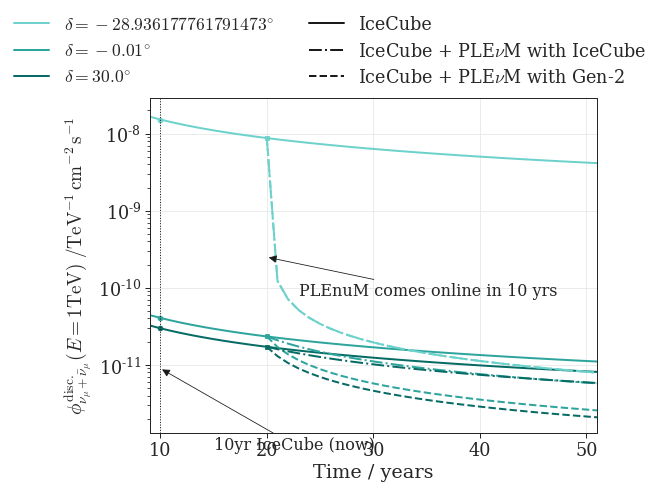

In [22]:
gamma = 3
# conversion to flux normalisation at 100TeV in 1/GeV /cm2/s
const = 1 #10**(-2*gamma) / 1.e3

t_0 = 10
t_new = np.arange(8, 52)
base_disc_10yr = splev(reference_sdecs, spl_10yr[gamma])

fig, ax = plt.subplots(figsize=(8, 7))
for i, dd in enumerate(reference_ddecs):
    time_evolution_base = base_disc_10yr[i] * (t_0 / t_new) ** 0.8
    p = ax.plot(t_new, time_evolution_base * const, label=fr"$\delta = {dd}^{{\circ}}$", color=colors[i])
    ax.scatter(t_0, base_disc_10yr[i] * const, color=colors[i])
    
t_1 = 20
t_new = np.arange(20, 52) # start Plenum after 20yr IC data (10yrs after "now")
for i, dd in enumerate(reference_ddecs):
    # base values at t_1 = 20yr
    # IC with 20 years
    base_ic = base_disc_10yr[i] * (t_0 / t_1) ** 0.8
    # plenum reference for 10 yrs data taking
    base_plenum = base_disc_10yr[i] * np.exp((det_eff[gamma]["IceCube"](reference_sdecs[i]) - det_eff[gamma]["Plenum-1"](reference_sdecs[i]))* 0.8)
    
    # plenum with gen2 instead of icecube
    # first, subtract icecube eff from plenum eff
    pl_tmp = np.exp(det_eff[gamma]["Plenum-1"](reference_sdecs[i])) - np.exp(det_eff[gamma]["IceCube"](reference_sdecs[i]))
    # then, add gen2
    pl_tmp += np.exp(det_eff[gamma]["Gen-2"](reference_sdecs[i]))
    base_plenum_gen2 = base_disc_10yr[i] * np.exp((det_eff[gamma]["IceCube"](reference_sdecs[i]) - np.log(pl_tmp))* 0.8)
    # time evolution
    # plenum starts at t_1=20yrs
    base_plenum_evo = base_plenum * (t_0 / (t_new-t_1)) ** 0.8
    base_plenum_gen2_evo = base_plenum_gen2 * (t_0 / (t_new-t_1)) ** 0.8
    # combine both base vals
    # 20yr IceCube and from then on combined Plenum evolution
    time_evolution = (base_ic ** (-1/0.8) + base_plenum_evo ** (-1/0.8)) ** -0.8
    time_evolution_gen2 = (base_ic ** (-1/0.8) + base_plenum_gen2_evo ** (-1/0.8)) ** -0.8
    p = ax.plot(t_new, time_evolution * const, color=colors[i], ls="-.")
    p = ax.plot(t_new, time_evolution_gen2 * const, color=colors[i], ls="--")
    ax.scatter(t_new[0], time_evolution[0] * const, color=colors[i], marker="s")

ax.set_yscale('log')
ax.set_xlabel(r"Time / years")
ax.set_ylabel(r"$\phi^{\mathrm{disc.}}_{\nu_\mu + \bar{\nu}_\mu}(E=1\rm TeV) ~ / \rm TeV^{-1} \, cm^{-2} \, s^{-1}$")
ax.axvline(10, ls=":", lw=1, color="k")
ax.annotate(
    "10yr IceCube (now)",
    xy=(10, 9.e-12), xytext=(15, 0.8e-12),
    arrowprops=dict(arrowstyle="-|>", color="k"),
    fontsize="small")
ax.annotate(
    "PLEnuM comes online in 10 yrs",
    xy=(20, 2.5e-10), xytext=(23, 0.8e-10),
    arrowprops=dict(arrowstyle="-|>", color="k"),
    fontsize="small")
ax.set_xlim(9, 51)

handles, labels = ax.get_legend_handles_labels()
handles.append(Line2D(
    range(1), range(1), color="k", 
    ls="-", label="IceCube"
))
handles.append(Line2D(
    range(1), range(1), color="k", 
    ls="-.", label=r"IceCube + PLE$\nu$M with IceCube"
))
handles.append(Line2D(
    range(1), range(1), color="k", 
    ls="--", label=r"IceCube + PLE$\nu$M with Gen-2"
))
        
fig.legend(
    handles=handles,
    loc='upper center', #mode='expand',
    ncol=2, frameon=False
)
fig.tight_layout()
plt.subplots_adjust(top = 0.8)
fig.savefig(f'../plots/PLENUM_ps_disc_pot_timeevolution_gamma{gamma}.pdf', bbox_inches="tight")

### NGC1068 time evolution

In [25]:
reference_ddecs

array([-2.89361778e+01, -1.00000000e-02,  3.00000000e+01])

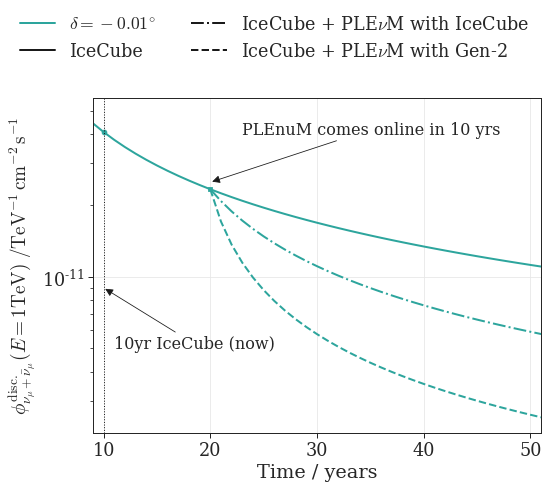

In [29]:
gamma = 3
# conversion to flux normalisation at 100TeV in 1/GeV /cm2/s
const = 1 #10**(-2*gamma) / 1.e3

t_0 = 10
t_new = np.arange(8, 52)
base_disc_10yr = splev(reference_sdecs, spl_10yr[gamma])

fig, ax = plt.subplots(figsize=(8, 7))
i = 1
dd = reference_ddecs[i]
time_evolution_base = base_disc_10yr[i] * (t_0 / t_new) ** 0.8
p = ax.plot(t_new, time_evolution_base * const, label=fr"$\delta = {dd}^{{\circ}}$", color=colors[i])
ax.scatter(t_0, base_disc_10yr[i] * const, color=colors[i])
    
t_1 = 20
t_new = np.arange(20, 52) # start Plenum after 20yr IC data (10yrs after "now")
# base values at t_1 = 20yr
# IC with 20 years
base_ic = base_disc_10yr[i] * (t_0 / t_1) ** 0.8
# plenum reference for 10 yrs data taking
base_plenum = base_disc_10yr[i] * np.exp((det_eff[gamma]["IceCube"](reference_sdecs[i]) - det_eff[gamma]["Plenum-1"](reference_sdecs[i]))* 0.8)

# plenum with gen2 instead of icecube
# first, subtract icecube eff from plenum eff
pl_tmp = np.exp(det_eff[gamma]["Plenum-1"](reference_sdecs[i])) - np.exp(det_eff[gamma]["IceCube"](reference_sdecs[i]))
# then, add gen2
pl_tmp += np.exp(det_eff[gamma]["Gen-2"](reference_sdecs[i]))
base_plenum_gen2 = base_disc_10yr[i] * np.exp((det_eff[gamma]["IceCube"](reference_sdecs[i]) - np.log(pl_tmp))* 0.8)
# time evolution
# plenum starts at t_1=20yrs
base_plenum_evo = base_plenum * (t_0 / (t_new-t_1)) ** 0.8
base_plenum_gen2_evo = base_plenum_gen2 * (t_0 / (t_new-t_1)) ** 0.8
# combine both base vals
# 20yr IceCube and from then on combined Plenum evolution
time_evolution = (base_ic ** (-1/0.8) + base_plenum_evo ** (-1/0.8)) ** -0.8
time_evolution_gen2 = (base_ic ** (-1/0.8) + base_plenum_gen2_evo ** (-1/0.8)) ** -0.8
p = ax.plot(t_new, time_evolution * const, color=colors[i], ls="-.")
p = ax.plot(t_new, time_evolution_gen2 * const, color=colors[i], ls="--")
ax.scatter(t_new[0], time_evolution[0] * const, color=colors[i], marker="s")

ax.set_yscale('log')
ax.set_xlabel(r"Time / years")
ax.set_ylabel(r"$\phi^{\mathrm{disc.}}_{\nu_\mu + \bar{\nu}_\mu}(E=1\rm TeV) ~ / \rm TeV^{-1} \, cm^{-2} \, s^{-1}$")
ax.axvline(10, ls=":", lw=1, color="k")
ax.annotate(
    "10yr IceCube (now)",
    xy=(10, 9.e-12), xytext=(11, 5e-12),
    arrowprops=dict(arrowstyle="-|>", color="k"),
    fontsize="small")
ax.annotate(
    "PLEnuM comes online in 10 yrs",
    xy=(20, 2.5e-11), xytext=(23, 4e-11),
    arrowprops=dict(arrowstyle="-|>", color="k"),
    fontsize="small")
ax.set_xlim(9, 51)

handles, labels = ax.get_legend_handles_labels()
handles.append(Line2D(
    range(1), range(1), color="k", 
    ls="-", label="IceCube"
))
handles.append(Line2D(
    range(1), range(1), color="k", 
    ls="-.", label=r"IceCube + PLE$\nu$M with IceCube"
))
handles.append(Line2D(
    range(1), range(1), color="k", 
    ls="--", label=r"IceCube + PLE$\nu$M with Gen-2"
))
        
fig.legend(
    handles=handles,
    loc='upper center', #mode='expand',
    ncol=2, frameon=False
)
fig.tight_layout()
plt.subplots_adjust(top = 0.8)
fig.savefig(f'../plots/NG1068_ps_disc_pot_timeevolution_gamma{gamma}.pdf', bbox_inches="tight")

In [82]:
significance_scaling = np.array(
    [[1.0, 0.00000e+0],
    [5.0, 2.36962e+0],
    [9.0, 4.05063e+0],
    [1.30e+1, 5.33333e+0],
    [1.70e+1, 6.23122e+0],
    [2.10e+1, 7.29114e+0]]
).T

lower_bound = np.array(
[   [5.002932551319649, 0.02586903799515028],
    [9.005865102639298, 2.573969280517379],
    [13.023460410557188, 4.009700889248177],
    [17.026392961876834, 5.0056588520614325],
    [20.985337243401766, 6.014551333872264]
]).T

In [35]:
from scipy.optimize import curve_fit

In [48]:
from scipy.special import erfinv, erf

In [49]:
def pval_to_sigma(pval):
    return erfinv(1 - pval) * np.sqrt(2)
def sigma_to_pval(sigma):
    return 1 - erf(sigma / np.sqrt(2))

In [78]:
NN = 202299
print(pval_to_sigma(sigma_to_pval(5) / NN))
print(pval_to_sigma(sigma_to_pval(5) / NN * 110))

6.985721612724645
6.292828195586338


In [68]:
pval_to_sigma(sigma_to_pval(5.13) * NN)

1.891073353459293

In [59]:
sigma_to_pval(4.2) / sigma_to_pval(5.1)

78.58449711082415

In [87]:
def fit_func(x, a, b):
    return a + x ** b
def inv_func(y, a, b):
    return (y - a) ** (1/b)

[-0.74179718  0.69041789]
16.87105574059425
21.03466556857293


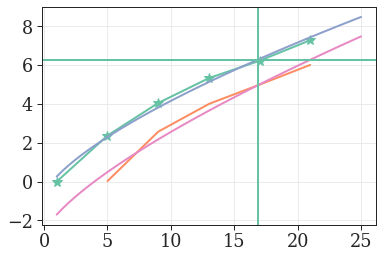

In [89]:
popt, _ = curve_fit(fit_func, significance_scaling[0], significance_scaling[1])
poptl, _ = curve_fit(fit_func, lower_bound[0], lower_bound[1])
print(popt)
plt.plot(significance_scaling[0], significance_scaling[1], marker="*", ms=10)
plt.plot(lower_bound[0], lower_bound[1])
xval = np.linspace(1, 25)
plt.plot(xval, fit_func(xval, *popt))
plt.plot(xval, fit_func(xval, *poptl))
p_sl_rq = pval_to_sigma(sigma_to_pval(5) / NN * 110)
plt.axhline(p_sl_rq)
plt.axvline(inv_func(p_sl_rq, *popt))
print(inv_func(p_sl_rq, *popt))
print(inv_func(p_sl_rq, *poptl))

## time evolution of sensitivity

In [23]:
ps_sens = dict()
ind_sens = dict()
xsd_sens = dict()
ic_10yr_sens = dict()
spl_10yr_sens = dict()

gamma = 2.0
ps_sens[gamma] = np.genfromtxt('../resources/sens_10yr_gamma-2.txt', delimiter=' ')
ind_sens[gamma] = np.argsort(ps_sens[gamma][:,0])
xsd_sens[gamma] = ps_sens[gamma][:,0][ind_sens[gamma] ]
ic_10yr_sens[gamma] = ps_sens[gamma][:,1][ind_sens[gamma] ]
spl_10yr_sens[gamma] = splrep(xsd_sens[gamma], ic_10yr_sens[gamma])

gamma = 3.0
ps_sens[gamma] = np.genfromtxt('../resources/sens_10yr_gamma-3.txt', delimiter=' ')
ind_sens[gamma] = np.argsort(ps_sens[gamma][:,0])
xsd_sens[gamma] = ps_sens[gamma][:,0][ind_sens[gamma] ]
ic_10yr_sens[gamma] = ps_sens[gamma][:,1][ind_sens[gamma] ]
spl_10yr_sens[gamma] = splrep(xsd_sens[gamma], ic_10yr_sens[gamma])

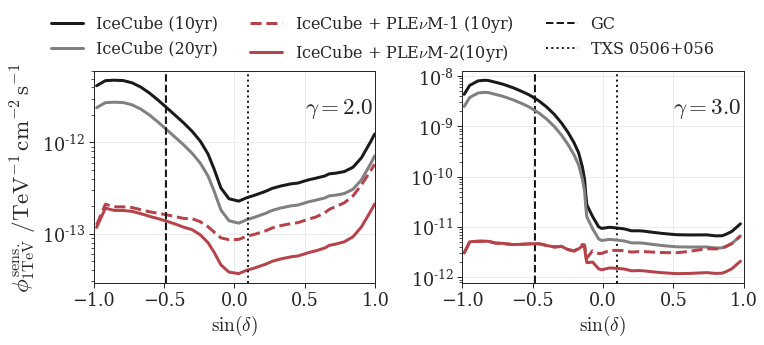

In [24]:
gamma= 2.0

ic_20yr = ps_sens[gamma][:,1][ind_sens[gamma] ] * (0.5 ** 0.8) # double time from 10yr baseline to 20yr
# gen2 10yr
gen2 = ps_sens[gamma][:,1][ind_sens[gamma] ] \
    * np.exp((det_eff[gamma]["IceCube"](xsd_sens[gamma]) - det_eff[gamma]["Gen-2"](xsd_sens[gamma]))* 0.8)
# plenum 10yr
plenum = ps_sens[gamma][:,1][ind_sens[gamma] ] \
    * np.exp((det_eff[gamma]["IceCube"](xsd_sens[gamma]) - det_eff[gamma]["Plenum-1"](xsd_sens[gamma]))* 0.8)
# 10 yr icecube, then 10yr plenum with icecube
ic_plenum = (ic_10yr_sens[gamma] ** (-1/0.8) + plenum ** (-1/0.8)) ** -0.8
# 10 yr icecube, then 10yr plenum with gen2 (instead of plenum with icecube only)
ic_plenum_gen2 = (plenum ** (-1/0.8) + gen2 ** (-1/0.8)) ** -0.8

# conversion to flux normalisation at 100TeV in 1/GeV /cm2/s
const = 1 #  10**(-2*gamma) / 1.e3
f, axes = plt.subplots(ncols=2, figsize=(11, 5))
ax = axes[0]
ax.plot(
    xsd_sens[gamma], ic_10yr_sens[gamma] * const,
    color="k",
    lw=3, label=r'IceCube (10yr)'
)
ax.plot(
    xsd_sens[gamma], ic_20yr * const,
    color="gray",
    lw=3, label=r'IceCube (20yr)')
ax.plot(
    xsd_sens[gamma], ic_plenum * const,
    color=colors[3], ls="--",
    lw=3, label=r'IceCube + PLE$\nu$M-1 (10yr)')
ax.plot(
    xsd_sens[gamma], ic_plenum_gen2 * const,
    color=colors[3],
    lw=3, label=r'IceCube + PLE$\nu$M-2(10yr)')
ax.set_xlabel(r'$\sin(\delta)$')
ax.set_yscale('log')
ax.set_xlim(-1, 1)
# add the location of the galactic center and TXS
ax.axvline(np.sin(sgr_a.icrs.dec), ls="--", color="k", label="GC")
ax.axvline(np.sin(txs0506.icrs.dec), ls=":", color="k", label="TXS 0506+056")
f.legend(loc='upper center', ncol=3, frameon=False, fontsize="small")
ax.text(0.75, 0.8, r'$\gamma={0:.1f}$'.format(gamma), fontsize="large", transform = ax.transAxes)
ax.set_ylabel(r"$\phi^{\mathrm{sens.}}_{1\rm TeV} ~ / \rm TeV^{-1} \, cm^{-2} \, s^{-1}$", fontsize="large")
ax.tick_params(axis='both', which='major')

gamma= 3.0
ic_20yr = ps_sens[gamma][:,1][ind_sens[gamma] ] * (0.5 ** 0.8) # double time from 10yr baseline to 20yr
# gen2 10yr
gen2 = ps_sens[gamma][:,1][ind_sens[gamma] ] \
    * np.exp((det_eff[gamma]["IceCube"](xsd_sens[gamma]) - det_eff[gamma]["Gen-2"](xsd_sens[gamma]))* 0.8)
# plenum 10yr
plenum = ps_sens[gamma][:,1][ind_sens[gamma] ] \
    * np.exp((det_eff[gamma]["IceCube"](xsd_sens[gamma]) - det_eff[gamma]["Plenum-1"](xsd_sens[gamma]))* 0.8)
# 10 yr icecube, then 10yr plenum with icecube
ic_plenum = (ic_10yr_sens[gamma] ** (-1/0.8) + plenum ** (-1/0.8)) ** -0.8
# 10 yr icecube, then 10yr plenum with gen2 (instead of plenum with icecube only)
ic_plenum_gen2 = (plenum ** (-1/0.8) + gen2 ** (-1/0.8)) ** -0.8

# conversion to flux normalisation at 100TeV in 1/GeV /cm2/s
const = 1 #  10**(-2*gamma) / 1.e3
ax = axes[1]
# add the location of the galactic center and TXS
ax.axvline(np.sin(sgr_a.icrs.dec), ls="--", color="k", label="GC")
ax.axvline(np.sin(txs0506.icrs.dec), ls=":", color="k", label="TXS 0506+056")
ax.plot(
    xsd_sens[gamma], ic_10yr_sens[gamma] * const,
    color="k",
    lw=3, label=r'IceCube (10yr)'
)
ax.plot(
    xsd_sens[gamma], ic_20yr * const,
    color="gray",
    lw=3, label=r'IceCube (20yr)')
ax.plot(
    xsd_sens[gamma], ic_plenum * const,
    color=colors[3], ls="--",
    lw=3, label=r'10yr IceCube + 10yr PLE$\nu$M')
ax.plot(
    xsd_sens[gamma], ic_plenum_gen2 * const,
    color=colors[3],
    lw=3, label=r'10yr IceCube + PLE$\nu$M with Gen-2 (10yr)')
ax.set_xlabel(r'$\sin(\delta)$')
ax.set_yscale('log')
ax.set_xlim(-1, 1)
ax.text(0.75, 0.8, r'$\gamma={0:.1f}$'.format(gamma), fontsize="large", transform = ax.transAxes)
ax.tick_params(axis='both', which='major')
f.tight_layout()
plt.subplots_adjust(top = 0.8)
f.savefig(f'../plots/PLENUM_ps_sens_comparison_gamma{gamma}.pdf', bbox_inches="tight")